## Summary: Systematic effects on Edelweiss C

One wonders if a different estimate on the widening necessary for the nuclear-recoil band would happen if there were systematic errors on e.g. the recorded voltage on the detector.

This notebook examines the effect of possible systematics on C.

In [1]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy import optimize
import lmfit as lmf
import emcee

import os.path
import pickle

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [2]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

## Only the ratio of V/$\epsilon$ matters

In the Edelweiss expression for the yield width, V and $\epsilon$ always appear as a ratio.

Therefore, our answer is sensitivity to the uncertainty in $V/\epsilon$, not the uncertainty of $V$ and $\epsilon$ separately.

In [3]:
sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                   pars, \
                                   aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

sig_nr_func_V = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                     {'V': 4.0*1.5, 'eps_eV': 3.0}, \
                                     aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

sig_nr_func_eps = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                     {'V': 4.0, 'eps_eV': 3.0/1.5}, \
                                     aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

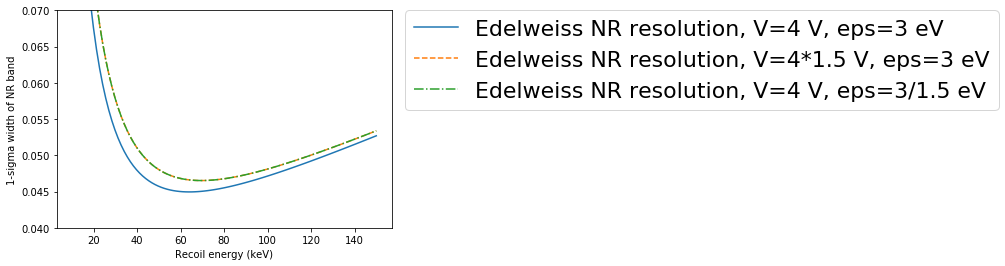

In [4]:
E_recoil_arr = np.linspace(10, 150, 100)

plt.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, V=4 V, eps=3 eV")
plt.plot(E_recoil_arr, sig_nr_func_V(E_recoil_arr), '--', label="Edelweiss NR resolution, V=4*1.5 V, eps=3 eV")
plt.plot(E_recoil_arr, sig_nr_func_eps(E_recoil_arr), '-.', label="Edelweiss NR resolution, V=4 V, eps=3/1.5 eV")

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of NR band")
plt.ylim(0.04, 0.07)

ax1 = plt.gca()
ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

In [5]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')
resNR_data = resNR_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

chisq for ER:  6.824467804985276
chisq for NR:  13.832136036326103
[[Variables]]
    ion_center_0keV:   1.3 (fixed)
    ion_guard_0keV:    1.5 (fixed)
    ion_122keV:        3.1 (fixed)
    heat_0keV:         0.4 (fixed)
    heat_122keV:       2.7 (fixed)
    aH:                0.01638269 (fixed)
    C:                 0.03478487 +/- 0.003368 (9.68%) (init= 0.04)
    m:                 9.3917e-05 +/- 7.09e-05 (75.53%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(C, m)                      = -0.906 
None


(0.04, 0.1)

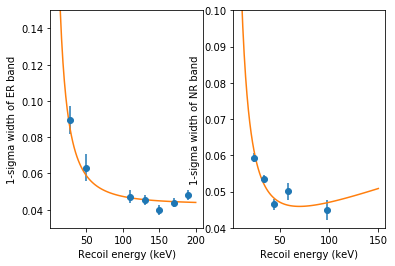

In [6]:
pars = {'V' : 4.0,'eps_eV' : 3.0}

ER_fit, NR_fit = edelweiss_fit(pars, ER_data, NR_data)
print(lmf.report_fit(NR_fit.params))

sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                 aH=ER_fit.params['aH'])

sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                   aH=NR_fit.params['aH'], C=NR_fit.params['C'], m=NR_fit.params['m'])

fig = plt.figure()
# the ER-band fit
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 200, 100)
ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax1.set_ylim(0.03, 0.15)

# the NR-band fit
ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 150, 100)
ax2.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, C=0.0313")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
ax2.set_ylim(0.04, 0.1)

chisq for ER:  122.10376418577482
chisq for NR:  69.93678528058301
[[Variables]]
    ion_center_0keV:   1.3 (fixed)
    ion_guard_0keV:    1.5 (fixed)
    ion_122keV:        3.1 (fixed)
    heat_0keV:         0.4 (fixed)
    heat_122keV:       2.7 (fixed)
    aH:                0.01088084 (fixed)
    C:                 0.02535878 +/- 0.005523 (21.78%) (init= 0.04)
    m:                 0.00020399 +/- 0.000109 (53.67%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(C, m)                      = -0.904 
None


(0.03, 0.15)

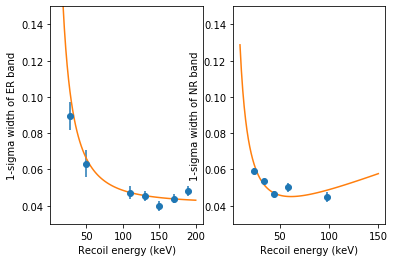

In [7]:
pars = {'V' : 1.5*4.0,'eps_eV' : 3.0}

ER_fit, NR_fit = edelweiss_fit(pars, ER_data, NR_data)
print(lmf.report_fit(NR_fit.params))

sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                 aH=ER_fit.params['aH'])

sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                   aH=NR_fit.params['aH'], C=NR_fit.params['C'], m=NR_fit.params['m'])

fig = plt.figure()
# the ER-band fit
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 200, 100)
ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax1.set_ylim(0.03, 0.15)

# the NR-band fit
ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 150, 100)
ax2.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, C=0.0313")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
ax2.set_ylim(0.03, 0.15)

chisq for ER:  130.38613845610854
chisq for NR:  12.642838844712458
[[Variables]]
    ion_center_0keV:   1.3 (fixed)
    ion_guard_0keV:    1.5 (fixed)
    ion_122keV:        3.1 (fixed)
    heat_0keV:         0.4 (fixed)
    heat_122keV:       2.7 (fixed)
    aH:                0.02528309 (fixed)
    C:                 0.04215935 +/- 0.002673 (6.34%) (init= 0.04)
    m:                 1.6220e-06 +/- 5.87e-05 (3616.58%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(C, m)                      = -0.908 
None


(0.03, 0.15)

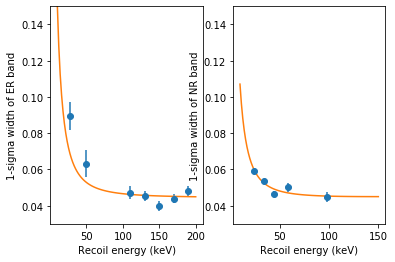

In [8]:
pars = {'V' : 0.5*4.0,'eps_eV' : 3.0}

ER_fit, NR_fit = edelweiss_fit(pars, ER_data, NR_data)
print(lmf.report_fit(NR_fit.params))

sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                 aH=ER_fit.params['aH'])

sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, \
                                   aH=NR_fit.params['aH'], C=NR_fit.params['C'], m=NR_fit.params['m'])

fig = plt.figure()
# the ER-band fit
ax1 = fig.add_subplot(1,2,1)
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 200, 100)
ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax1.set_ylim(0.03, 0.15)

# the NR-band fit
ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

E_recoil_arr = np.linspace(10, 150, 100)
ax2.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, C=0.0313")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
ax2.set_ylim(0.03, 0.15)

## Fit with an MCMC method

A (maximum likelihood) global fit of the ER and NR band with aH, C, m, and the scale allowed to vary seems to prefer a scale of 0.5 rather than 1.  

The Edelweiss fit procedure fixes the scale of V/eps at 1 and has the following chi-square values for the ER and NR bands:

chisq for ER:  6.824467804985276

chisq for NR:  13.832136036326103

The maximum likelihood global fit chooses a scale of about 0.5 for V/eps and has the following chi-square values:

chisq for ER:  16.09105041402365

chisq for NR:  5.512907776270328


In [9]:
def log_likelihood(theta, ER_data, NR_data):
    aH, C, m, scale = theta
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x, y, yerr = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    model_ER = sigER_func(x_ER)
    sigma2_ER = yerr_ER**2
    model_NR = sigNR_func(x)
    sigma2_NR = yerr**2
    return -0.5*np.sum((y-model_NR)**2/sigma2_NR + np.log(2*np.pi*sigma2_NR) \
                       + (y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER))


def lmf_negative_ll(params, Erecoil_ER, sigma_ER, sigma_err_ER, Erecoil_NR, sigma_NR, sigma_err_NR):
    #aH, C, m, scale = params
    
    return -log_likelihood(params, ER_data, NR_data)

In [10]:
def new_log_prior(theta):
    aH, C, m, scale = theta
    if 0 < aH < 0.1 and 0.02 < C < 0.05 and -1e-3 < m < 1e-3 and 0 < scale < 100:
        return 0.0
    return -np.inf

In [11]:
def new_log_probability(theta, ER_data, NR_data):
    lp = new_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ER_data, NR_data)

In [12]:
# start at about the minimum
aH, C, m, scale = 0.0164, 0.0348, 9.39E-5, 1.0

## Find the minimum likelihood

In [16]:
from scipy.optimize import minimize
np.random.seed(42)

initial = np.array([aH, C, m, scale]) #+ 0.001*np.random.randn(2)
soln = minimize(lmf_negative_ll, initial, args=(ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err'], \
                                                NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']))


print (soln)

params = lmf.Parameters()
params.add('ion_center_0keV', value=ion_center_0keV, vary=False)
params.add('ion_guard_0keV', value=ion_guard_0keV, vary=False)
params.add('ion_122keV', value=ion_122keV, vary=False)
params.add('heat_0keV', value=heat_0keV, vary=False)
params.add('heat_122keV', value=heat_122keV, vary=False)
params.add('aH', value=soln.x[0])
params.add('C', value=soln.x[1])
params.add('m', value=soln.x[2])
params.add('scale', value=soln.x[3])

resER = residualER(params, ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err'], pars)
resNR = residualNR(params, NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err'], pars)

print("chisq for ER: ", np.sum(np.square(resER)))
print("chisq for NR: ", np.sum(np.square(resNR)))

      fun: -46.51358788503108
 hess_inv: array([[ 7.16850009e-05,  4.01375824e-05, -5.28722901e-07,
        -3.08511540e-03],
       [ 4.01375824e-05,  2.69673785e-05, -3.81948411e-07,
        -1.74614205e-03],
       [-5.28722901e-07, -3.81948411e-07,  5.89383409e-09,
         2.29719777e-05],
       [-3.08511540e-03, -1.74614205e-03,  2.29719777e-05,
         1.33988618e-01]])
      jac: array([-0.47935247,  0.04925632,  1.17372942, -0.00791311])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 492
      nit: 14
     njev: 80
   status: 2
  success: False
        x: array([2.47593201e-02, 4.21130339e-02, 2.78502269e-06, 5.05335337e-01])
chisq for ER:  16.09105041402365
chisq for NR:  5.512907776270328


In [14]:
Test = True

# random walks starting near the minimum
ndim, nwalkers = 4, 100
pos = [[aH, C, m, scale] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    
if not Test:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, new_log_probability, args=(ER_data, NR_data))
    sampler.run_mcmc(pos, 500)
else:
    with open('data/edelweiss_C_systematicErrors_sampler.pkl', 'rb') as f:  
         sampler = pickle.load(f)

In [15]:
print (sampler.)

SyntaxError: invalid syntax (<ipython-input-15-888b90cb03bf>, line 1)

In [ ]:
if not os.path.exists('data/edelweiss_C_systematicErrors_sampler.pkl'):
    with open('data/edelweiss_C_systematicErrors_sampler.pkl', 'wb') as f: 
        pickle.dump([sampler], f)

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
samples = sampler.chain
labels = ["aH", "C", "m", "scale"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
import corner
print(np.shape(samples))
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["aH", "$C$", "$m$", "scale"],
                      truths=[aH, C, slope, scale])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

Erecoil = np.linspace(10, 200, 500)

for aH, C, m, scale in samples[np.random.randint(len(samples), size=200)]:
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    ax1.plot(Erecoil, sigER_func(Erecoil), color="k", alpha=0.05)
    ax2.plot(Erecoil, sigNR_func(Erecoil), color="k", alpha=0.05)

# plot the best fit
# GGA3 parameters from Edelweiss tables
aH, C, m, scale = 0.0164, 0.0348, 9.39E-5, 1.0
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
par_dict = {'V' : scale*4.0,'eps_eV' : 3.0}

ref_sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                par_dict, aH)
    
ref_sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                  par_dict, aH, C, m)
ax1.plot(Erecoil, ref_sigER_func(Erecoil), color="r", lw=2, alpha=0.8)
ax2.plot(Erecoil, ref_sigNR_func(Erecoil), color="r", lw=2, alpha=0.8)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
ax2.set_ylim(0.04, 0.1)